In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Importación de las imágenes

In [3]:
data_dir = "Data/train_eyes"
batch_size = 16
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=100,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1234 files belonging to 2 classes.
Using 988 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=100,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1234 files belonging to 2 classes.
Using 246 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Closed', 'Open']


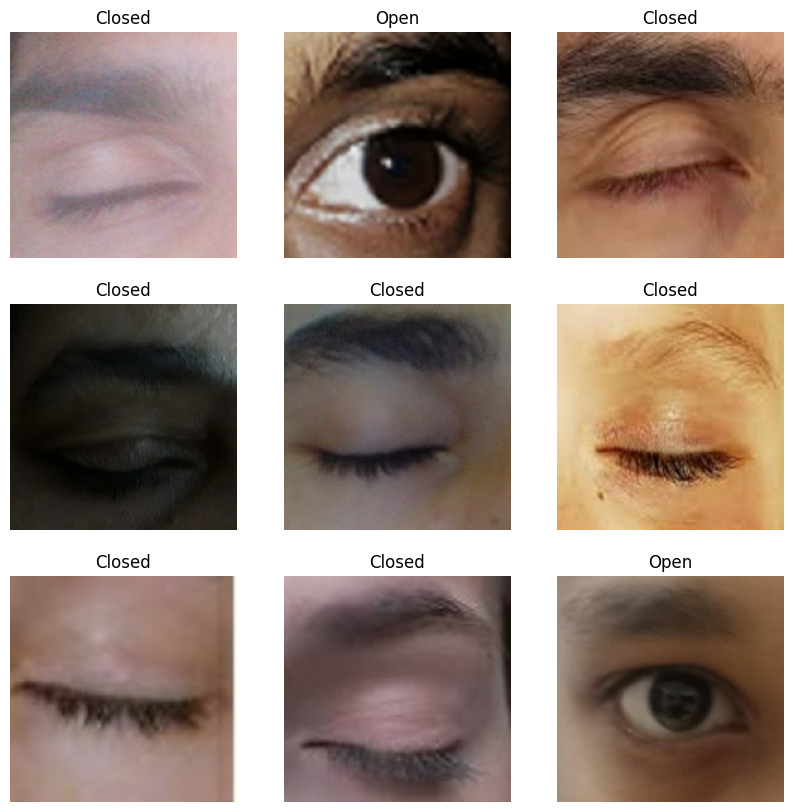

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 180, 180, 3)
(16,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.cache()
val_ds = val_ds.cache()

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.03588227 0.6624401


## Creación del modelo

In [12]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(units=100, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 129600)            0

## Entrenamiento

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
62/62 [==============================] - 6s 59ms/step - loss: 0.7644 - accuracy: 0.7702 - val_loss: 0.2959 - val_accuracy: 0.8780
Epoch 2/10
62/62 [==============================] - 3s 50ms/step - loss: 0.1813 - accuracy: 0.9332 - val_loss: 0.1478 - val_accuracy: 0.9431
Epoch 3/10
62/62 [==============================] - 3s 49ms/step - loss: 0.1155 - accuracy: 0.9534 - val_loss: 0.1346 - val_accuracy: 0.9390
Epoch 4/10
62/62 [==============================] - 3s 49ms/step - loss: 0.1130 - accuracy: 0.9585 - val_loss: 0.1300 - val_accuracy: 0.9309
Epoch 5/10
62/62 [==============================] - 3s 49ms/step - loss: 0.1649 - accuracy: 0.9585 - val_loss: 0.1902 - val_accuracy: 0.9268
Epoch 6/10
62/62 [==============================] - 3s 48ms/step - loss: 0.1059 - accuracy: 0.9717 - val_loss: 0.1777 - val_accuracy: 0.9350
Epoch 7/10
62/62 [==============================] - 3s 49ms/step - loss: 0.1311 - accuracy: 0.9605 - val_loss: 0.1654 - val_accuracy: 0.9350
Epoch 8/10
62

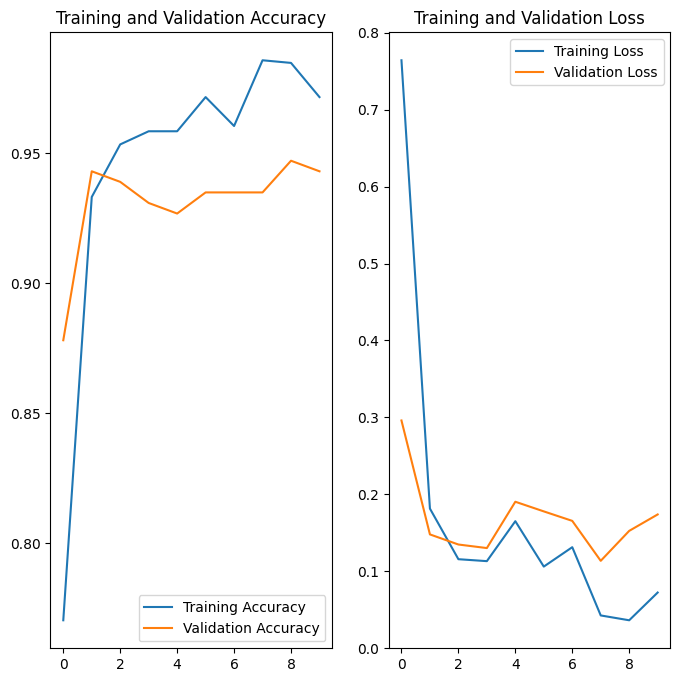

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predicciones con dataset de testeo

In [17]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 214ms/step
This image most likely belongs to Open with a 73.10 percent confidence.
